In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [3]:
bip_df = pd.read_csv(r'C:\Users\marco\OneDrive\Desktop\ADV Project\Graph_Creation Ysocial\y_bipartite_edges.csv')

In [9]:
bip_df.head()

,source,target,interaction,date,day
0,user_145,post_1,created,1900-02-01,02-01
1,user_145,post_278,replied,1900-02-06,02-06
2,user_145,post_234,replied,1900-02-07,02-07
3,user_145,post_25,replied,1900-02-06,02-06
4,user_145,post_729,replied,1900-02-10,02-10


## Statistical Analysis

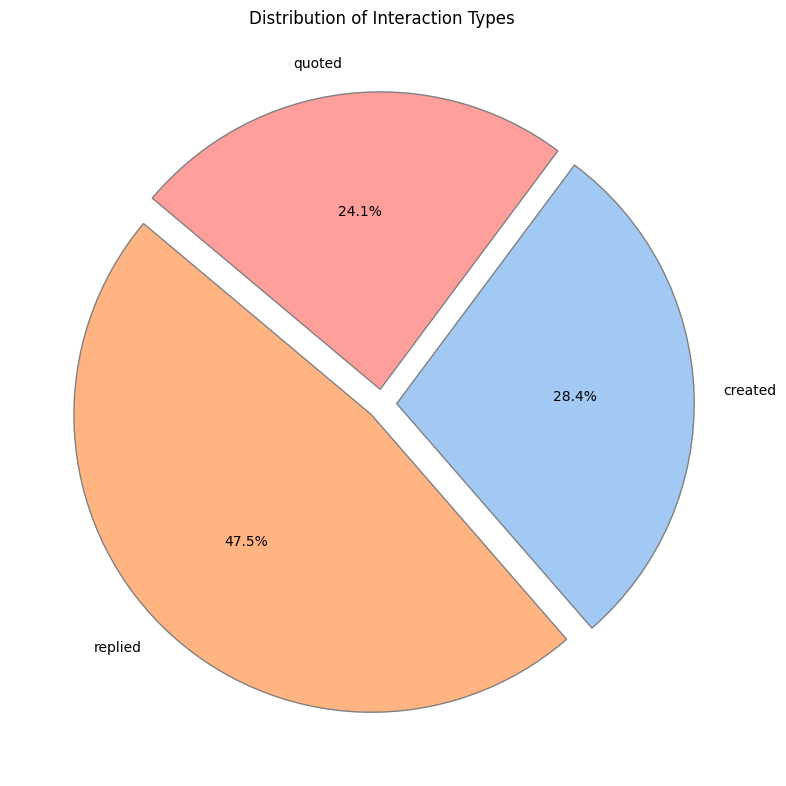

In [6]:
# Check the distribution of values in the 'interaction' column
interaction_counts = bip_df['interaction'].value_counts()

# Define specific colors for each interaction type
custom_colors = {
    'replied': sns.color_palette("pastel")[1],  # Orange
    'quoted': sns.color_palette("pastel")[3],   # Red
    'created': sns.color_palette("pastel")[0],  # Blue
}

# Map colors to the interaction types in the correct order
colors = [custom_colors[interaction] for interaction in interaction_counts.index]

# Slightly "explode" all slices for better visibility
explode = [0.05] * len(interaction_counts)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(interaction_counts.values, 
        labels=interaction_counts.index, 
        autopct='%1.1f%%',  # Show percentages with one decimal place
        startangle=140,    # Start the first slice at 140 degrees
        colors=colors, 
        explode=explode,   # Add explosion effect
        wedgeprops={'edgecolor': 'gray', 'linewidth': 1})  # Enhance edge visibility

plt.title("Distribution of Interaction Types")
plt.tight_layout()
plt.show()


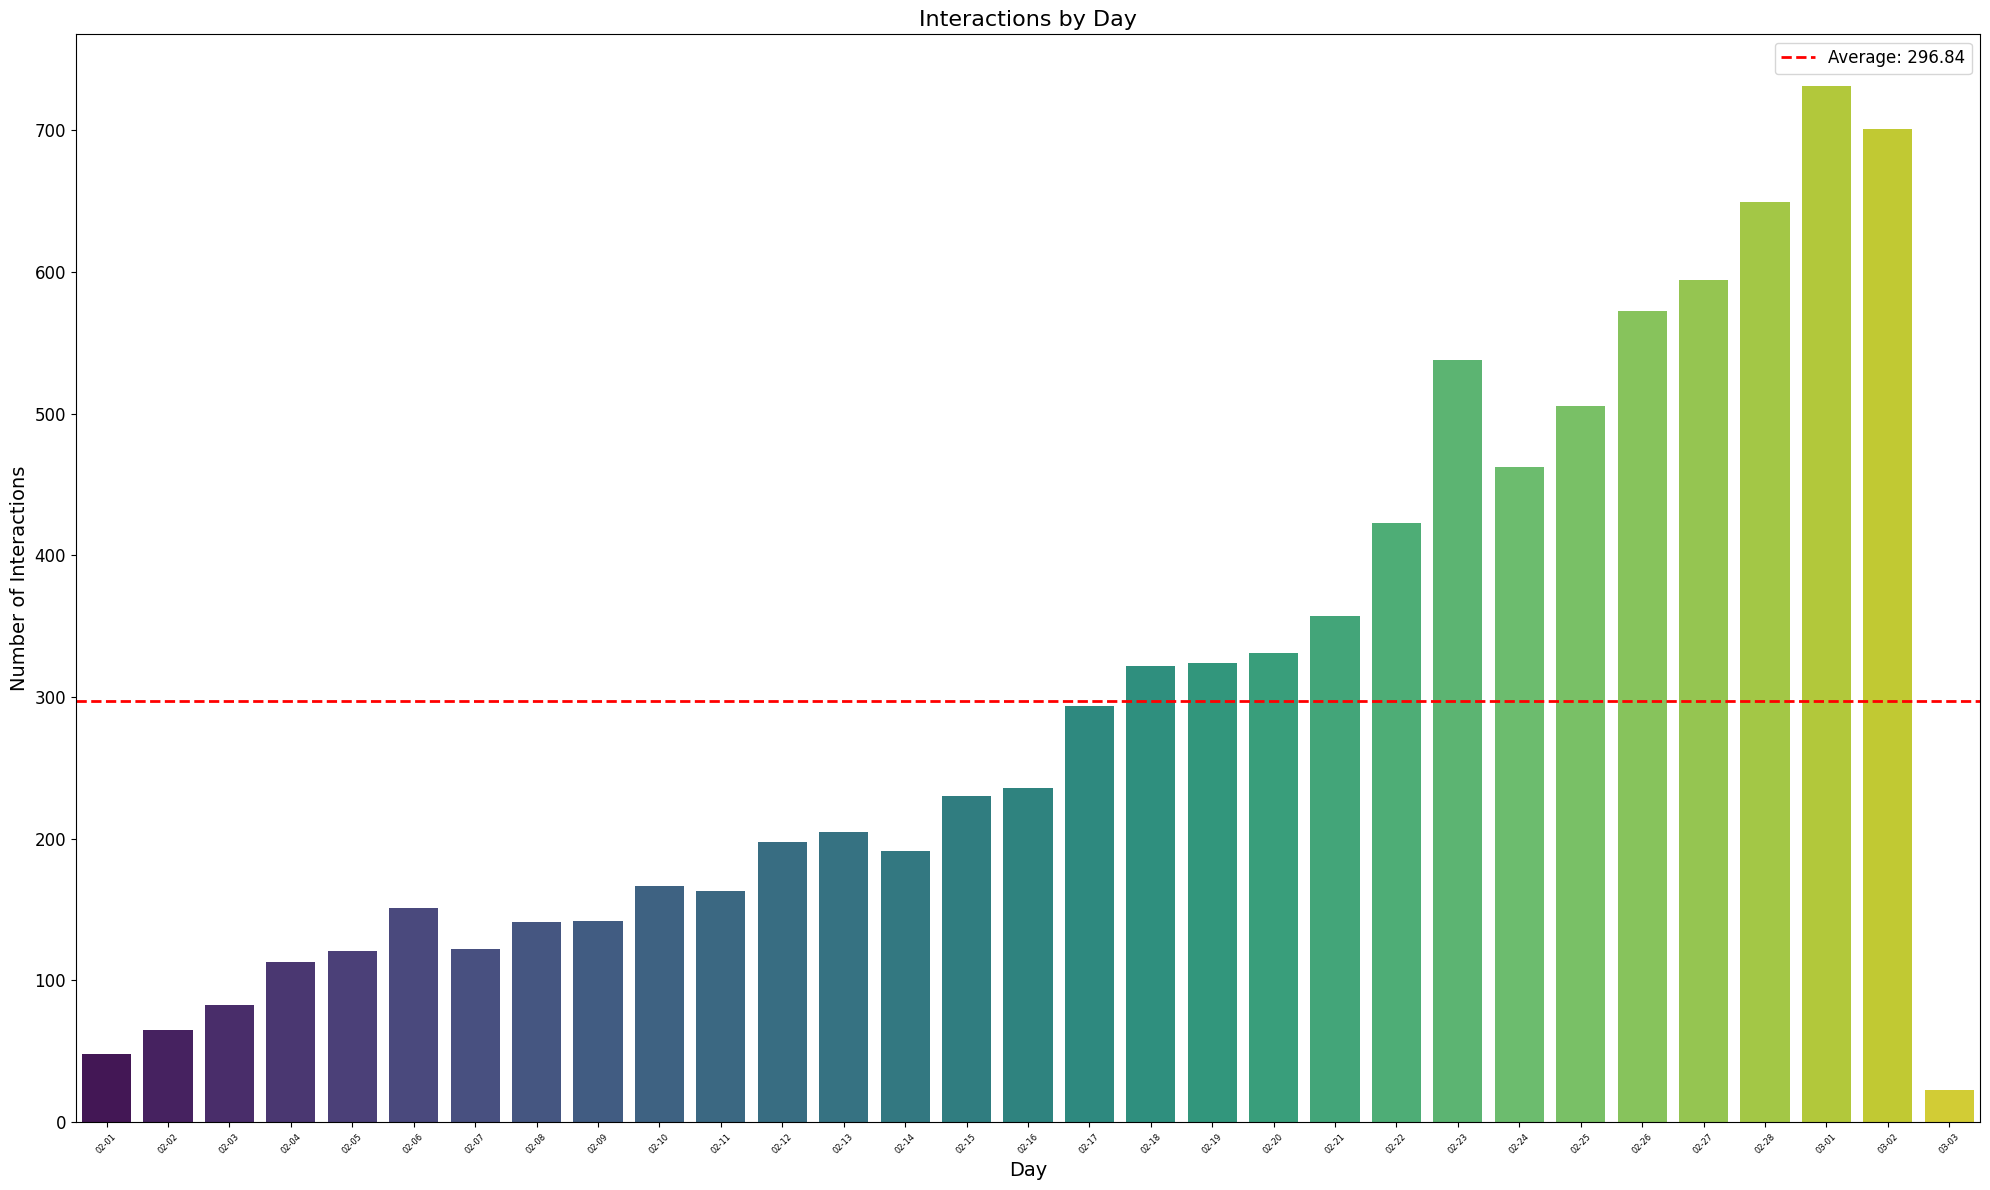

In [7]:
# Convert the 'date' column to datetime format using '%m-%d' (MM-DD)
bip_df['date'] = pd.to_datetime(bip_df['date'], format='%m-%d')

# Extract day from the 'date' column (keeping it as MM-DD format)
bip_df['day'] = bip_df['date'].dt.strftime('%m-%d')  # Format as MM-DD string

# Count interactions per day by grouping
interactions_per_day = bip_df.groupby('day').size().reset_index(name='interactions',)

# Calculate the average number of interactions per day
average_interactions = interactions_per_day['interactions'].mean()

# Plot the data using Seaborn
plt.figure(figsize=(20, 12))
sns.barplot(
    x='day', 
    y='interactions', 
    data=interactions_per_day,
    palette= 'viridis',
    hue='day'  # Fixed color to avoid palette warnings
)

# Add a red horizontal line to mark the average interactions
plt.axhline(average_interactions, color='red', linestyle='--', linewidth=2, label=f'Average: {average_interactions:.2f}')

# Adjust spacing between bars and add labels
plt.title("Interactions by Day", fontsize=16)
plt.xlabel("Day", fontsize=14)
plt.ylabel("Number of Interactions", fontsize=14)
plt.xticks(rotation=45, fontsize=6)  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Filter for 'created' interactions only
created_interactions = bip_df[bip_df['interaction'] == 'created']

# Count the number of 'created' interactions per user (user_id)
user_interactions = created_interactions.groupby('source').size().reset_index(name='interaction_count')

# Calculate the average number of interactions per user
average_interactions = user_interactions['interaction_count'].mean()

# Get the top 10 most prolific users
top_10_users = user_interactions.sort_values(by='interaction_count', ascending=False).head(10)

# Print the average and the top 10 users
print(f"Average number of interactions per user: {average_interactions:.2f}")
print("\nTop 10 most prolific users:")
print(top_10_users)

Average number of interactions per user: 3.30

Top 10 most prolific users:
       source  interaction_count
153  user_211                 17
632   user_73                 16
127  user_187                 14
283  user_342                 13
11   user_102                 12
173  user_230                 12
302   user_36                 12
339    user_4                 12
699   user_83                 11
137  user_198                 11


## Clustering Analysis

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


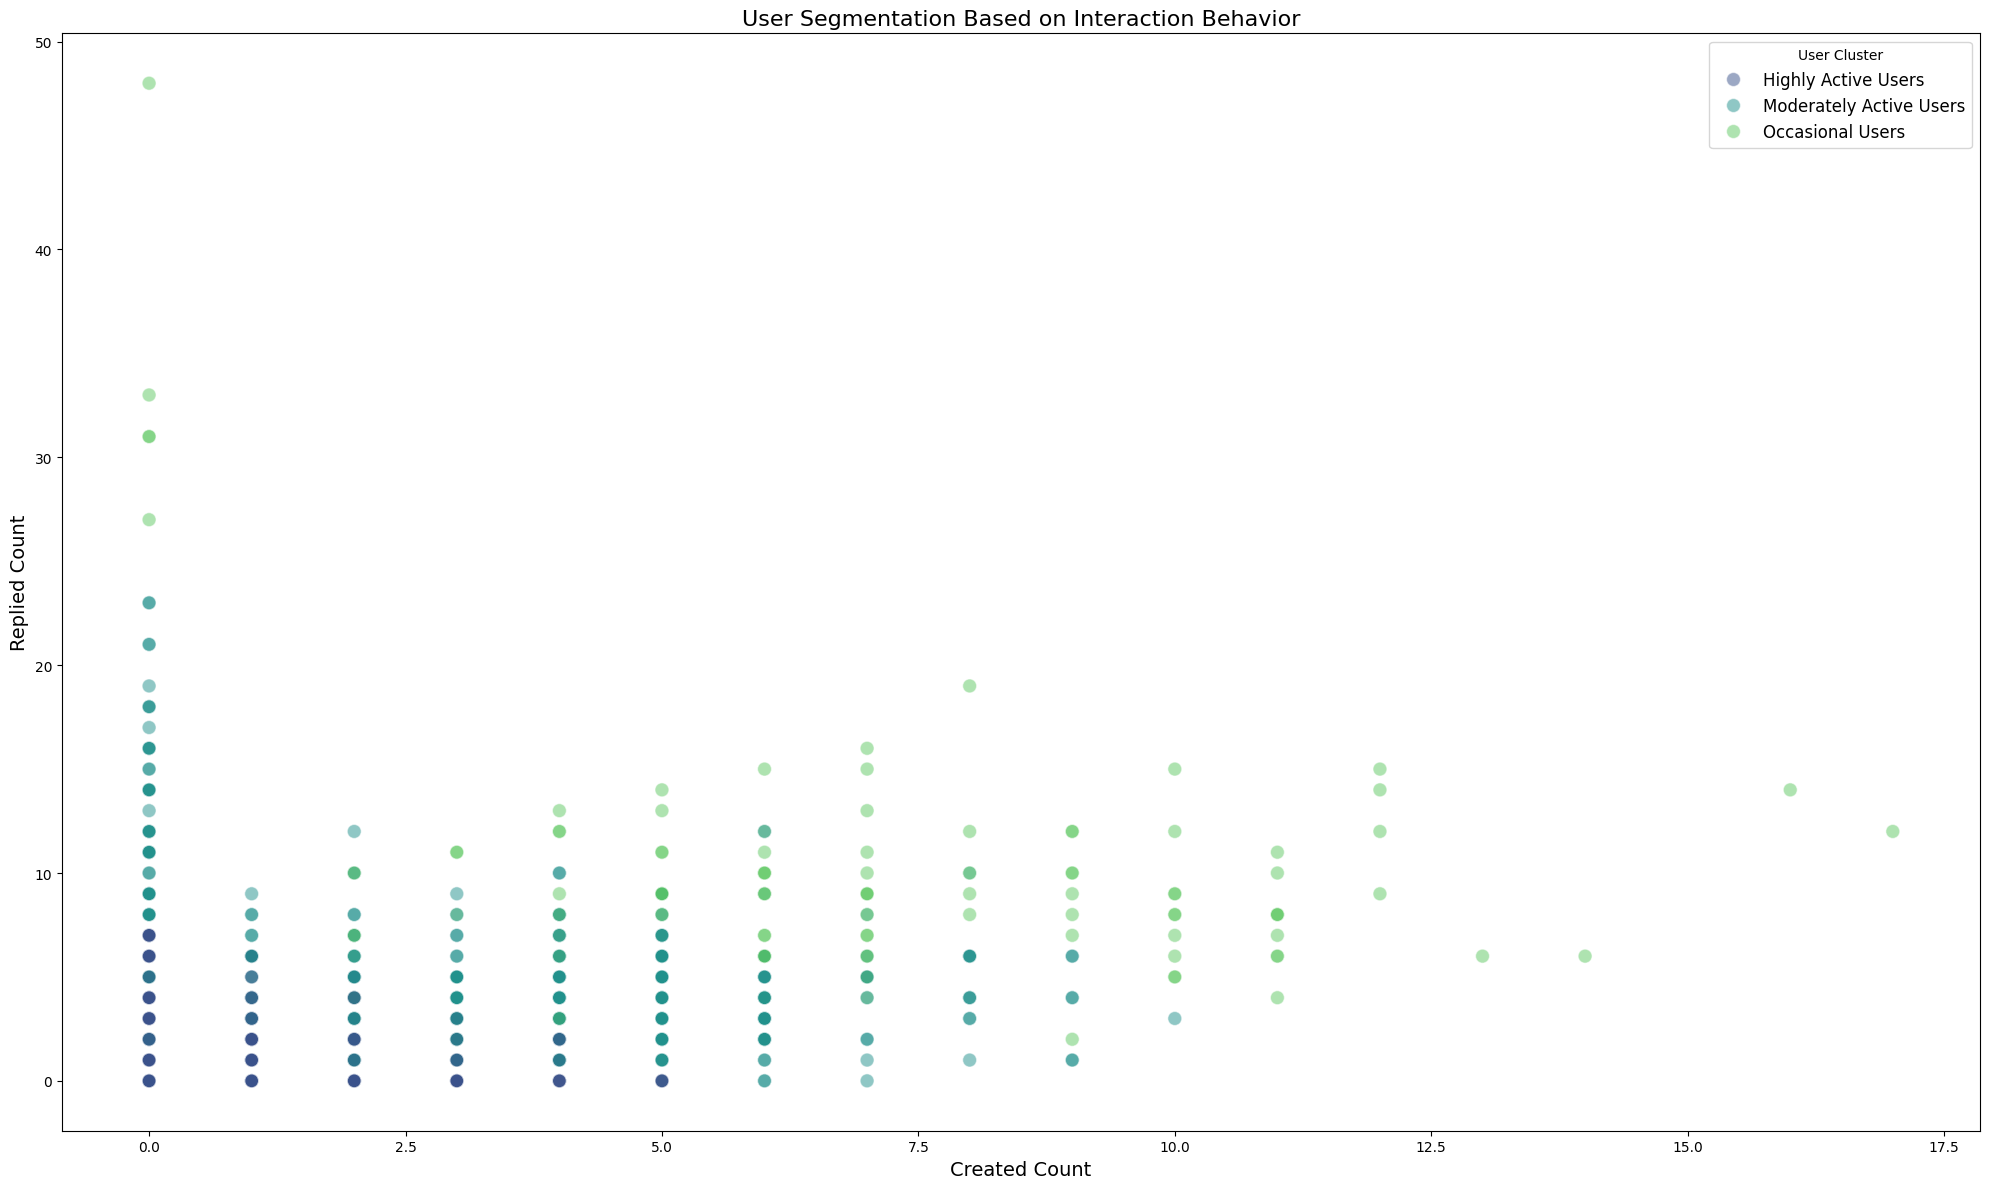

Average Interactions by Cluster:
                         avg_created  avg_reposted  avg_quoted  avg_replied  \
cluster_label                                                                 
Highly Active Users         0.654150           0.0    0.359684     1.417984   
Moderately Active Users     3.410615           0.0    2.709497     5.276536   
Occasional Users            6.971429           0.0    8.400000     9.971429   

                         avg_total_interactions  
cluster_label                                    
Highly Active Users                    2.431818  
Moderately Active Users               11.396648  
Occasional Users                      25.342857  

Number of Users in Each Cluster:
cluster_label
Highly Active Users        1012
Moderately Active Users     358
Occasional Users            105
Name: count, dtype: int64


In [14]:
# Step 1: Group by 'user_id' and calculate interaction counts for each type of interaction
user_activity = bip_df.groupby('source').agg(
    created_count=('interaction', lambda x: (x == 'created').sum()),
    reposted_count=('interaction', lambda x: (x == 'reposted').sum()),
    quoted_count=('interaction', lambda x: (x == 'quoted').sum()),
    replied_count=('interaction', lambda x: (x == 'replied').sum()),
    total_interactions=('interaction', 'size')  # Total number of interactions (all types)
).reset_index()

# Step 2: Standardize the data (important for clustering algorithms)
scaler = StandardScaler()
user_activity_scaled = scaler.fit_transform(user_activity[['created_count', 'reposted_count', 'quoted_count', 'replied_count', 'total_interactions']])

# Step 3: Apply K-Means Clustering (Let's use 3 clusters for now)
kmeans = KMeans(n_clusters=3, random_state=42)
user_activity['cluster'] = kmeans.fit_predict(user_activity_scaled)

# Step 4: Rename clusters with descriptive labels
cluster_labels = {0: 'Moderately Active Users', 1: 'Highly Active Users', 2: 'Occasional Users'}
user_activity['cluster_label'] = user_activity['cluster'].map(cluster_labels)

# Step 5: Visualize the clusters
plt.figure(figsize=(20, 12))
sns.scatterplot(data=user_activity, x='created_count', y='replied_count', hue='cluster_label', palette='viridis', s=100, alpha=0.5)

# Customize the plot with titles and legend
plt.title('User Segmentation Based on Interaction Behavior', fontsize=16)
plt.xlabel('Created Count', fontsize=14)
plt.ylabel('Replied Count', fontsize=14)
plt.legend(title='User Cluster', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

# Step 6: Analyze the average interactions per user in each cluster
cluster_averages = user_activity.groupby('cluster_label').agg(
    avg_created=('created_count', 'mean'),
    avg_reposted=('reposted_count', 'mean'),
    avg_quoted=('quoted_count', 'mean'),
    avg_replied=('replied_count', 'mean'),
    avg_total_interactions=('total_interactions', 'mean')
)

print("Average Interactions by Cluster:")
print(cluster_averages)

# Step 7: Additional Analysis: Number of users in each cluster
cluster_counts = user_activity['cluster_label'].value_counts()
print("\nNumber of Users in Each Cluster:")
print(cluster_counts)

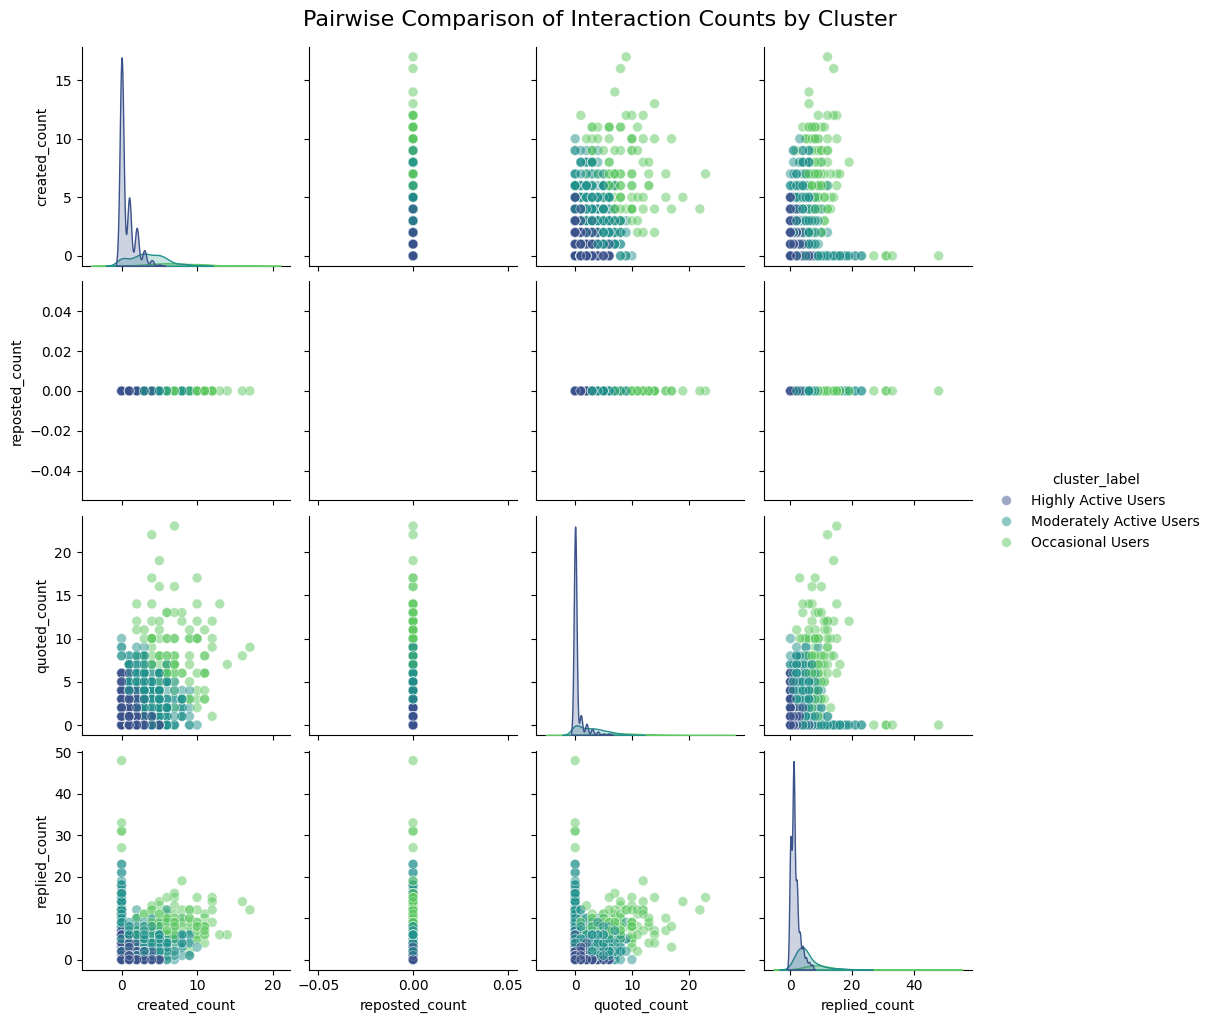

In [15]:
sns.pairplot(
    user_activity, 
    vars=['created_count', 'reposted_count', 'quoted_count', 'replied_count'],
    hue='cluster_label', 
    palette='viridis', 
    diag_kind='kde', 
    plot_kws={'alpha': 0.5, 's': 50}
)
plt.suptitle('Pairwise Comparison of Interaction Counts by Cluster', y=1.02, fontsize=16)
plt.show()


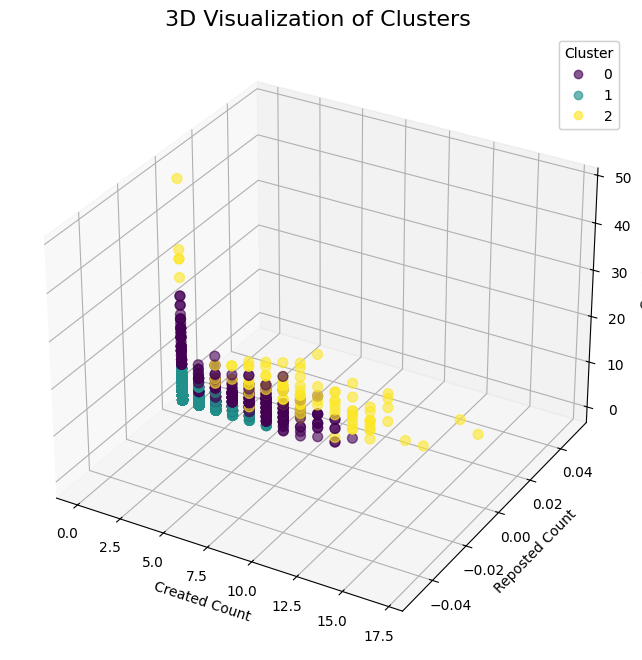

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    user_activity['created_count'], 
    user_activity['reposted_count'], 
    user_activity['replied_count'], 
    c=user_activity['cluster'], 
    cmap='viridis', 
    s=50, alpha=0.6
)
ax.set_title('3D Visualization of Clusters', fontsize=16)
ax.set_xlabel('Created Count')
ax.set_ylabel('Reposted Count')
ax.set_zlabel(' Count')
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
plt.show()

## Engagement Rates

In [17]:
bip_df['date'] = pd.to_datetime(bip_df['date'], format='%m-%d')  # Adjust format as needed
bip_df['day_of_week'] = bip_df['date'].dt.day_name()  # Extract day of the week
bip_df['month'] = bip_df['date'].dt.month_name()  # Extract month

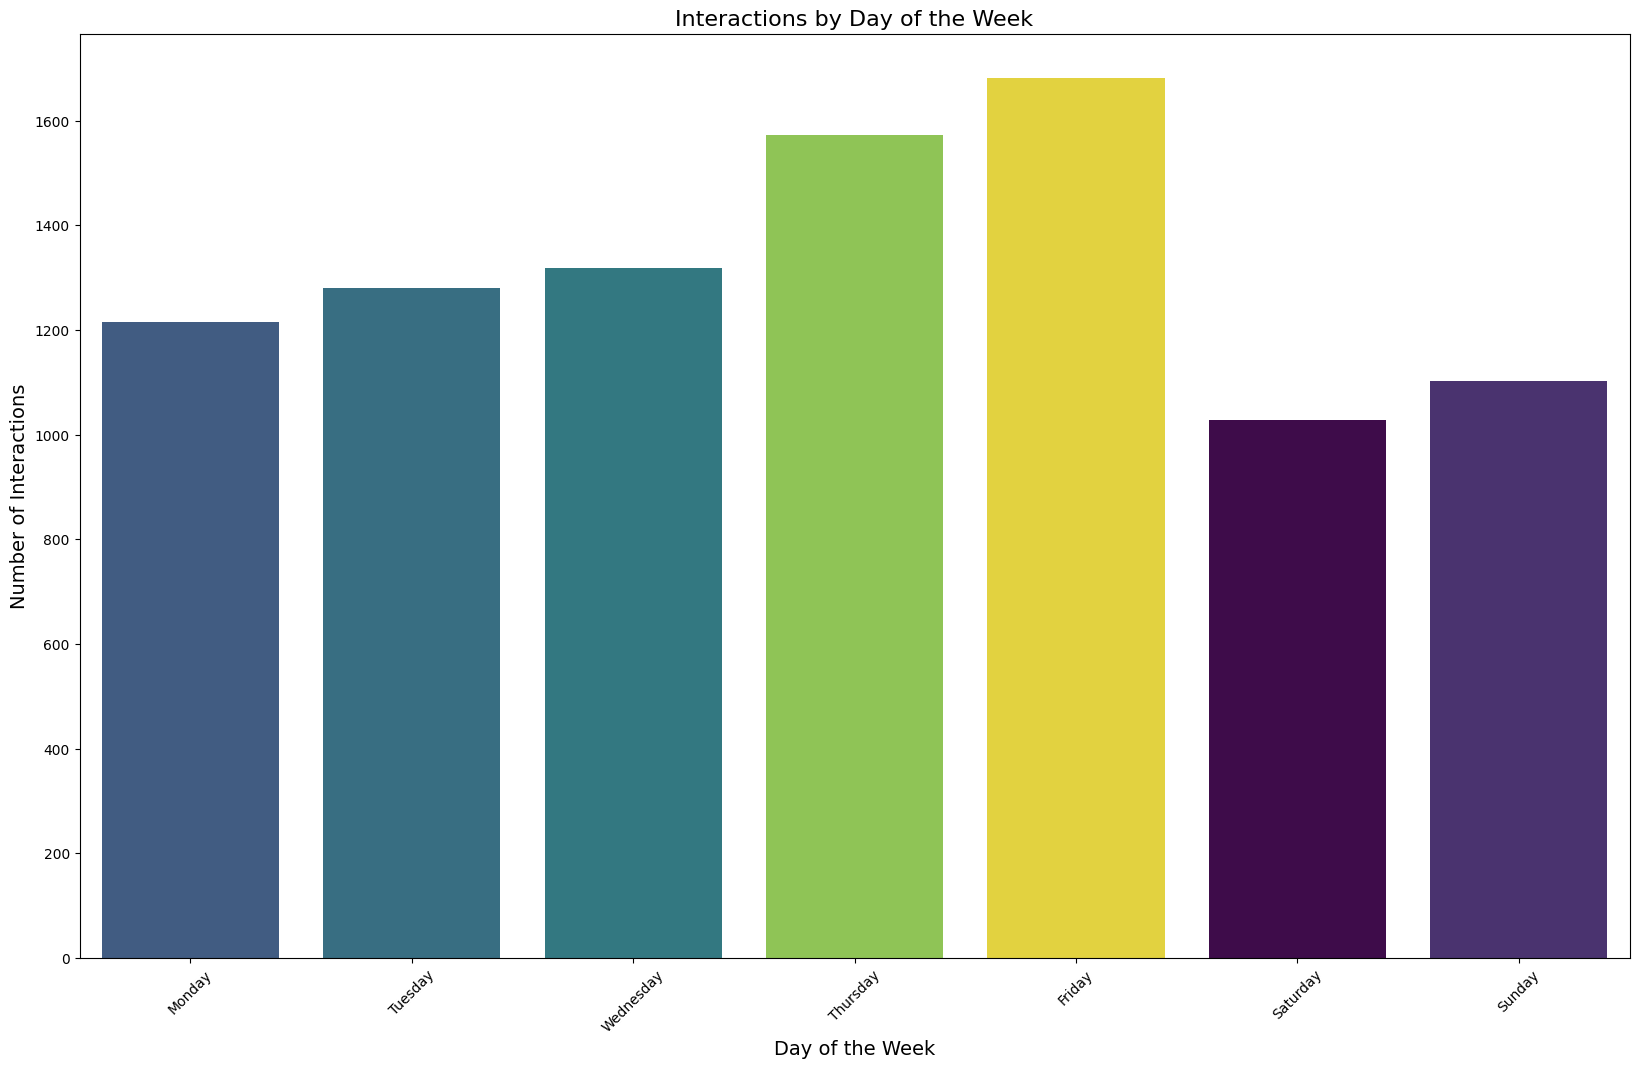

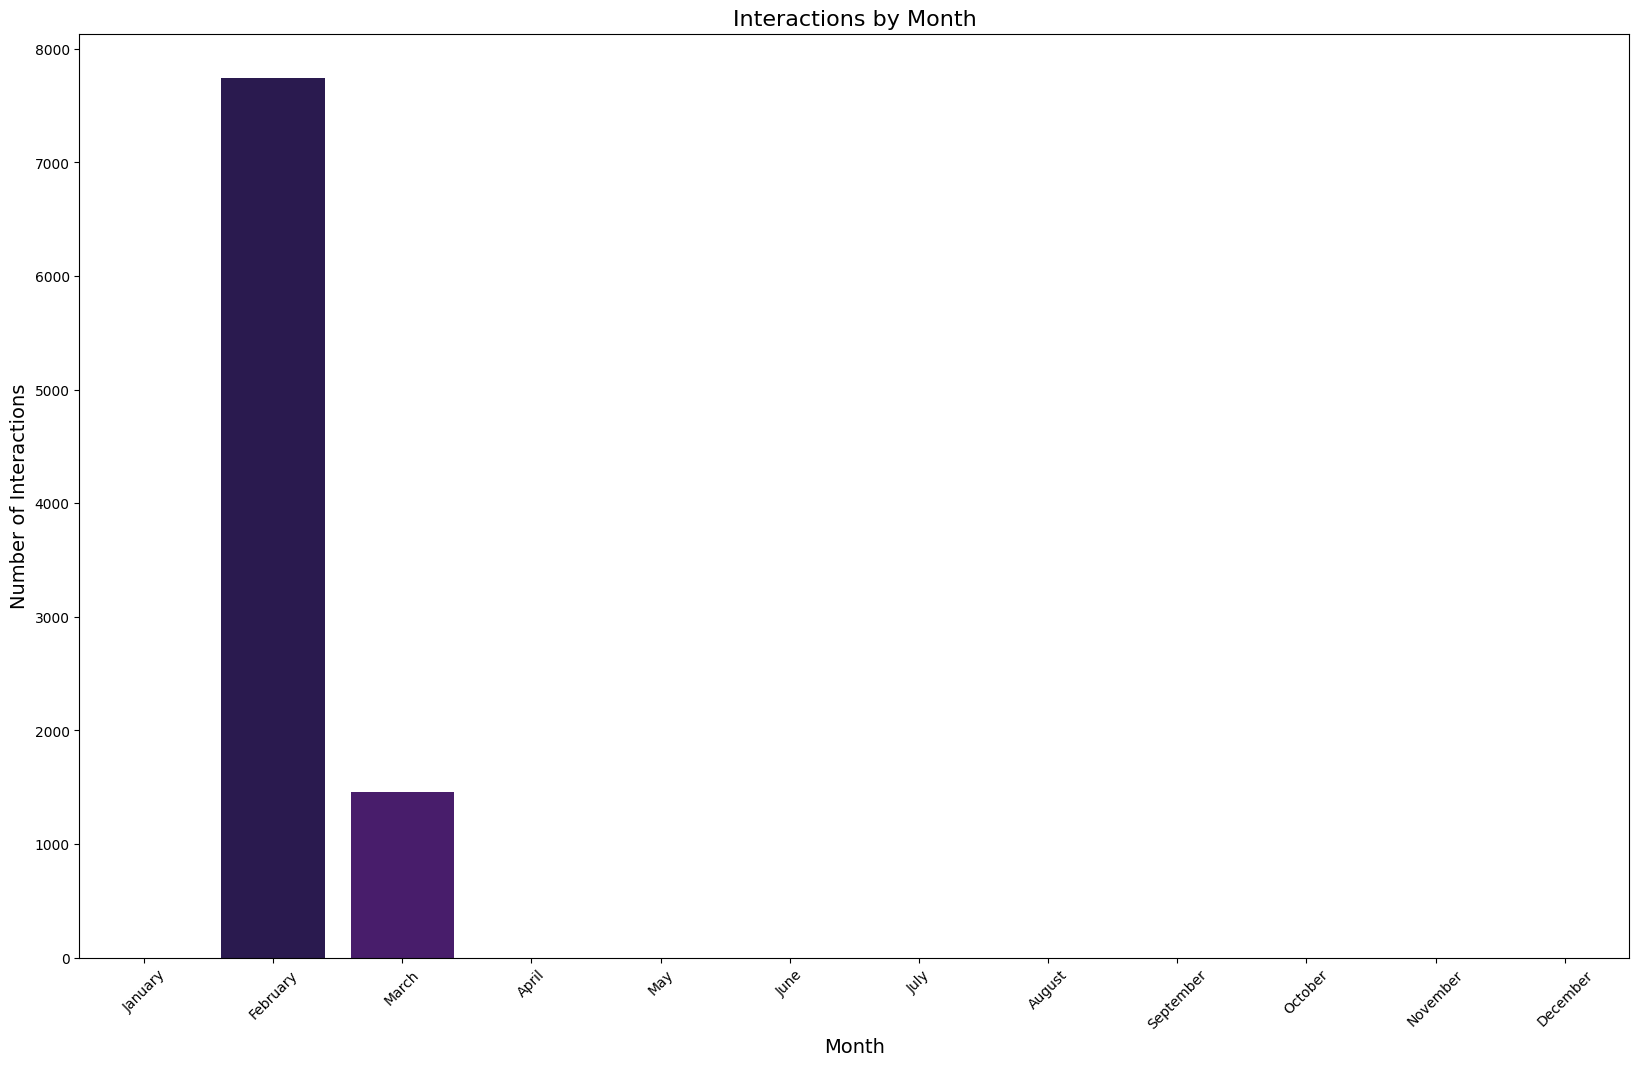

In [18]:
# Aggregate total interactions per day of the week
day_of_week_activity = bip_df.groupby('day_of_week').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Ensure correct order
)

# Plot day-of-week activity
plt.figure(figsize=(20, 12))
sns.barplot(x=day_of_week_activity.index, y=day_of_week_activity.values, palette='viridis', hue= day_of_week_activity, legend=False)
plt.title('Interactions by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Aggregate total interactions per month
month_activity = bip_df.groupby('month').size().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot month activity
plt.figure(figsize=(20, 12))
sns.barplot(x=month_activity.index, y=month_activity.values, palette='magma', hue=month_activity.index, legend=False)
plt.title('Interactions by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.show()

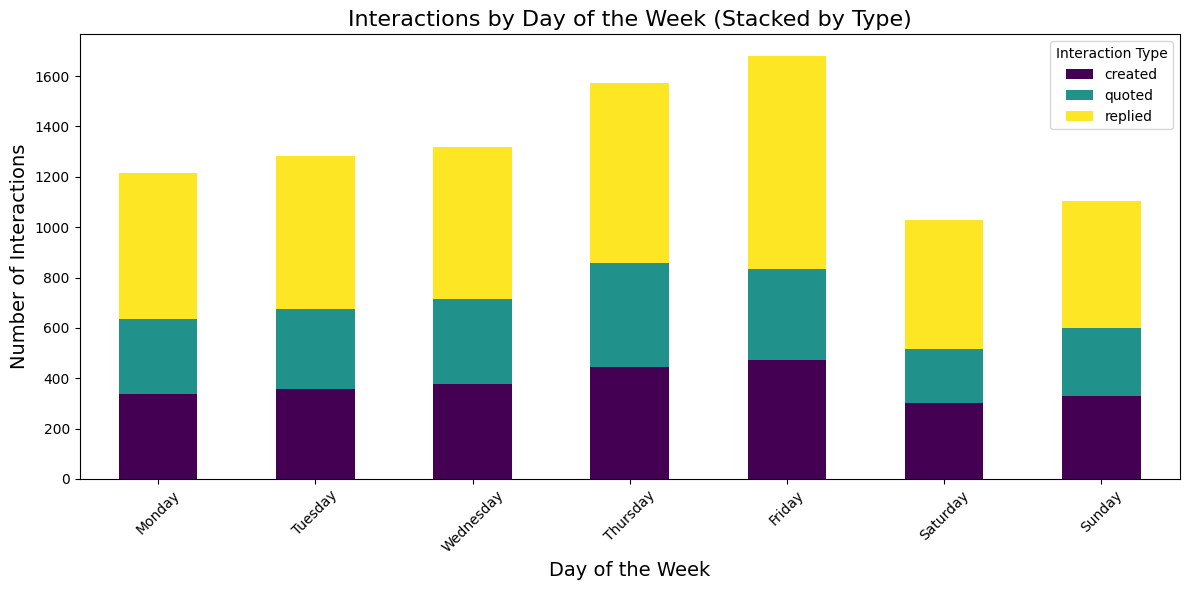

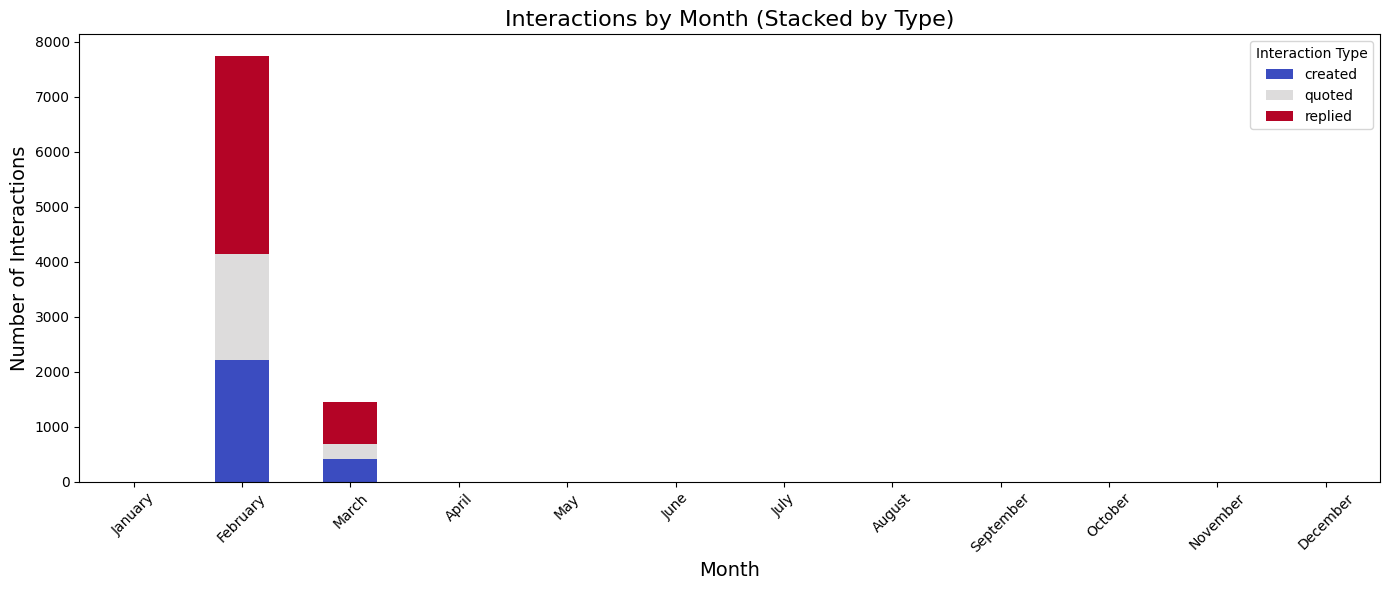

In [31]:
# Group by day of the week and interaction type
day_interaction_trends = bip_df.groupby(['day_of_week', 'interaction']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot as a stacked bar chart
day_interaction_trends.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Interactions by Day of the Week (Stacked by Type)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Interaction Type')
plt.tight_layout()
plt.show()

# Similarly, for months:
month_interaction_trends = bip_df.groupby(['month', 'interaction']).size().unstack().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot as a stacked bar chart
month_interaction_trends.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='coolwarm')
plt.title('Interactions by Month (Stacked by Type)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Interaction Type')
plt.tight_layout()
plt.show()

In [21]:
# Ensure the 'date' column is in datetime format
bip_df['date'] = pd.to_datetime(bip_df['date'], format='%m-%d')  # Adjust format if necessary

# Group by 'user_id' to get first and last interaction dates
user_engagement = bip_df.groupby('source').agg(
    first_interaction=('date', 'min'),
    last_interaction=('date', 'max')
).reset_index()

# Calculate the lifespan of each user's activity
user_engagement['engagement_duration'] = (user_engagement['last_interaction'] - user_engagement['first_interaction']).dt.days

Engagement Duration Summary:
count    1475.000000
mean        5.989153
std         8.021588
min         0.000000
25%         0.000000
50%         2.000000
75%        10.000000
max        29.000000
Name: engagement_duration, dtype: float64


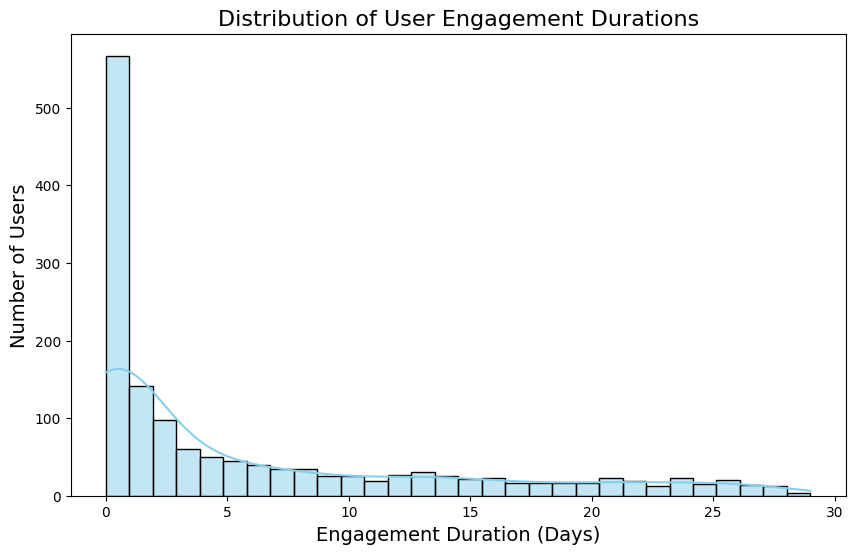

In [22]:
# Summary statistics
engagement_summary = user_engagement['engagement_duration'].describe()
print("Engagement Duration Summary:")
print(engagement_summary)

# Distribution of engagement durations
plt.figure(figsize=(10, 6))
sns.histplot(user_engagement['engagement_duration'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of User Engagement Durations', fontsize=16)
plt.xlabel('Engagement Duration (Days)', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.show()

Churn Rate: 11.53%


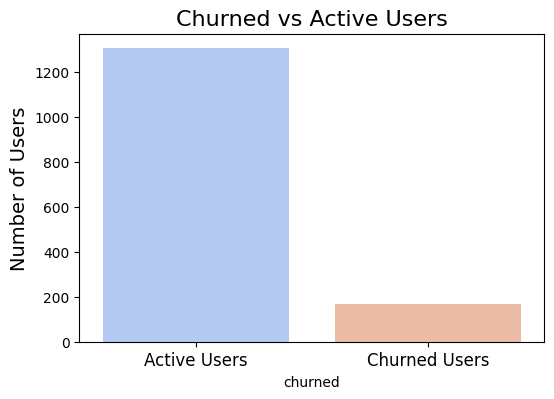

In [23]:
# Define a "churn cutoff" date
churn_cutoff_date = bip_df['date'].max() - pd.Timedelta(days=15)

# Identify users who have not interacted after the cutoff date
user_engagement['churned'] = user_engagement['last_interaction'] < churn_cutoff_date

# Calculate the churn rate
churn_rate = user_engagement['churned'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

# Count churned and active users
churn_counts = user_engagement['churned'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='coolwarm', hue=churn_counts.index, legend=False)
plt.title('Churned vs Active Users', fontsize=16)
plt.xticks([0, 1], ['Active Users', 'Churned Users'], fontsize=12)
plt.ylabel('Number of Users', fontsize=14)
plt.show()
